# SPKIR CG data deep dive 1.1
### Ref Des: CP01CNSM-RID26-08-SPKIRB000

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import os
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

from ooi_data_explorations.common import get_annotations, add_annotation_qc_flags
import ooi_data_explorations.common as common

from ooinet import M2M

from qartod_testing.timeseries import nanfill_time_gaps

In [2]:
# Set parameters for data request 
refdes = 'CP01CNSM-RID26-08-SPKIRB000'
site, node, sensor = refdes.split('-', 2)

In [3]:
methods = common.list_methods(site, node, sensor)
streams = {}

for method in methods:
    streams[method] = common.list_streams(site, node, sensor, method)

streams


{'recovered_host': ['spkir_abj_dcl_instrument_recovered'],
 'telemetered': ['spkir_abj_dcl_instrument']}

In [4]:
# View deployment information
deployments = M2M.get_deployments(refdes)
deployments

,deploymentNumber,uid,assetId,latitude,longitude,depth,deployStart,deployEnd,deployCruise,recoverCruise
0,1,CGINS-SPKIRB-00238,2407,40.13678,-70.76978,7.0,2013-11-21 18:16:00,2014-04-18 10:33:00,KN214,KN217
1,2,CGINS-SPKIRB-00272,1392,40.1339,-70.7789,7.0,2014-12-13 18:47:00,2014-12-15 20:58:00,KN224,KN224
2,3,CGINS-SPKIRB-00272,1392,40.14022,-70.77128,7.0,2015-05-07 17:34:00,2015-10-23 19:40:00,AT27,AT31
3,4,CGINS-SPKIRB-00291,1332,40.13323,-70.77843,7.0,2015-10-23 18:49:00,2016-04-04 12:03:00,AT31,AR1-07
4,5,CGINS-SPKIRB-00270,1395,40.14037,-70.77133,7.0,2016-05-13 13:50:00,2016-10-13 19:34:00,AR4,AR8
5,6,CGINS-SPKIRB-00291,1332,40.13342,-70.77847,7.0,2016-10-13 18:36:00,2017-06-09 16:05:00,AR8,AR18
6,7,CGINS-SPKIRB-00270,1395,40.139817,-70.77115,7.0,2017-06-09 14:24:00,2017-11-01 20:33:00,AR18,AR24
7,8,CGINS-SPKIRB-00275,1406,40.133383,-70.7783,7.0,2017-10-29 14:15:00,2018-03-29 19:37:00,AR24,AR28
8,9,CGINS-SPKIRB-00299,1342,40.13975,-70.77128,7.0,2018-03-24 21:32:00,2018-10-29 12:31:00,AR28,AR31
9,10,CGINS-SPKIRB-00271,1397,40.133367,-70.7777,7.0,2018-10-30 01:48:00,2019-04-07 18:08:00,AR31,AR34


In [5]:
# Define path on local machine to downloaded data

out_path = os.path.join(os.path.expanduser('~'), 'ooidata/m2m/', site.lower())
out_path = os.path.abspath(out_path)
if not os.path.exists(out_path):
    os.makedirs(out_path)

The `for` loop above that retrieves the available streams for a given method tells us that each method only has one available data stream. Next, we will download data for the method/stream pairs.

<hr>

### Recovered host data

In [6]:
# Set method and stream strings
method = methods[0]
stream = streams[method][0]
start = deployments[0]["deployStart"]

# Set file name and path to data file
data_file = '-'.join([refdes, method, stream]) + '.nc'
file_path = os.path.join(out_path, data_file)

# Print file path to check
file_path

'C:\\Users\\kylene.cooley\\ooidata\\m2m\\cp01cnsm\\CP01CNSM-RID26-08-SPKIRB000-recovered_host-spkir_abj_dcl_instrument_recovered.nc'

In [10]:
# Check for locally stored data to import first, then request and download data if the file does not yet exist in the ooidata/m2m/site folder
if os.path.exists(file_path):
    # Open the local dataset if it exists
    host_data = xr.load_dataset(file_path)
else:
    # Download and save data to a netcdf file to ooidata directory in user root
    
    # data = combine_delivery_methods(site, node, sensor)                       
    # There is a combine_delivery_methods() in qartod_ce_spkir.py by Chris W., but I don't yet know how well it works or the pre-processing that it applies.
    
    r = common.m2m_request(site, node, sensor, method, stream)
    host_data = common.m2m_collect(r)
    
    # Temporarily drop variables with fill values not handled well while writing netcdf to disk
    host_data = host_data.drop_vars(['instrument_id', 'dcl_controller_timestamp', 'serial_number'])
    host_data.to_netcdf(file_path, mode='w', format='NETCDF4', engine='h5netcdf')

In [22]:
# View annotations
annotations = get_annotations(site, node, sensor)
annotations = pd.DataFrame(annotations)
annotations

# Note: none of the beginDTs or endDTs are in a human-readable format.

,@class,id,subsite,node,sensor,method,stream,beginDT,endDT,annotation,exclusionFlag,source,qcFlag,parameters
0,.AnnotationRecord,363,CP01CNSM,RID26,08-SPKIRB000,telemetered,None,1445626140000,1459771380000,Data not telemetered.,False,leila@marine.rutgers.edu,not_available,[]
1,.AnnotationRecord,504,CP01CNSM,RID26,08-SPKIRB000,None,None,1385057700000,1397779200000,Data not recoverable.,False,leila@marine.rutgers.edu,None,[]
2,.AnnotationRecord,103,CP01CNSM,None,None,None,None,1392595200000,1397779200000,Surface buoy exploded due to hydrogen build-up...,False,swhite@whoi.edu,not_operational,[]
3,.AnnotationRecord,519,CP01CNSM,RID26,08-SPKIRB000,None,None,1418496420000,1418677080000,Data not recoverable.,False,leila@marine.rutgers.edu,None,[]
4,.AnnotationRecord,1379,CP01CNSM,RID26,None,telemetered,None,1524504120000,1540864080000,Power down - Instrument Disabled.,False,leila@marine.rutgers.edu,not_operational,[]
5,.AnnotationRecord,709,CP01CNSM,None,None,None,None,1418496420000,1418677080000,Deployment 2: Short deployment due to the fuel...,False,cdobson@whoi.edu,None,[]
6,.AnnotationRecord,1773,CP01CNSM,RID26,08-SPKIRB000,None,None,1569609000000,1668172860000,The use of UV lamps has been implemented for b...,False,swhite@whoi.edu,None,[]
7,.AnnotationRecord,2914,CP01CNSM,RID26,None,None,None,1626256800000,1627300800000,Deployment 14: * UPDATED 2021-07-26: NSIF powe...,False,cdobson@whoi.edu,not_operational,[]
8,.AnnotationRecord,4253,CP01CNSM,RID26,None,telemetered,None,1657843200000,1658102400000,Deployment 16: A gap in telemetered data is pr...,False,cdobson@whoi.edu,None,[]
9,.AnnotationRecord,4581,CP01CNSM,RID26,08-SPKIRB000,None,None,1649601300000,1668172860000,Deployment 16: The UV light failured during th...,False,cdobson@whoi.edu,None,[]


In [23]:
# Add qc flags for annotations retrieved above
if not annotations.empty:
    annotations = annotations.drop(columns=['@class'])
    annotations['beginDate'] = pd.to_datetime(annotations.beginDT, unit='ms').dt.strftime('%Y-%m-%dT%H:%M:%S')
    annotations['endDate'] = pd.to_datetime(annotations.endDT, unit='ms').dt.strftime('%Y-%m-%dT%H:%M:%S')

    # create an annotation-based quality flag
    data_edit = add_annotation_qc_flags(host_data, annotations)

    # clean-up the data, removing values that were marked as fail either from the quality checks or in the
    # annotations, and all data collected after the cut off date
    data_edit = data_edit.where(data_edit.rollup_annotations_qc_results != 4)

In [27]:
# Check structure of edited data and contents
data_edit

<xarray.Dataset>
Dimensions:                            (time: 40081955, spectra: 7)
Coordinates:
  * spectra                            (spectra) int32 0 1 2 3 4 5 6
  * time                               (time) datetime64[ns] 2015-05-07T17:45...
Data variables:
    internal_temperature               (time) float32 123.0 123.0 ... 148.0
    spkir_abj_cspp_downwelling_vector  (time, spectra) float64 32.51 ... -0.0...
    passed_checksum                    (time) float32 1.0 1.0 1.0 ... 1.0 1.0
    internal_timestamp                 (time) datetime64[ns] 1900-01-01 ... 1...
    frame_counter                      (time) float32 nan 1.0 ... 151.0 152.0
    vin_sense                          (time) float32 283.0 270.0 ... 286.0
    sample_delay                       (time) float32 -133.0 -133.0 ... -133.0
    deployment                         (time) float64 3.0 3.0 3.0 ... 16.0 16.0
    va_sense                           (time) float32 178.0 178.0 ... 176.0
    timer                              (time) float64 4.9 5.99 ... 156.5 157.6
    channel_array                      (time, spectra) float64 2.255e+09 ... ...
    rollup_annotations_qc_results      (time) float64 0.0 0.0 0.0 ... 9.0 9.0
Attributes: (12/69)
    node:                               RID26
    comment:                            Data collected from the OOI M2M API a...
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  recovered_host
    stream:                             spkir_abj_dcl_instrument_recovered
    ...                                 ...
    geospatial_lon_resolution:          0.1
    geospatial_vertical_units:          meters
    geospatial_vertical_resolution:     0.1
    geospatial_vertical_positive:       down
    lat:                                40.13325
    lon:                                -70.778317

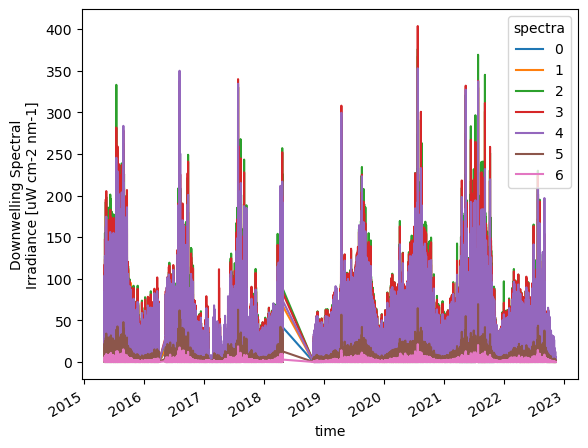

In [25]:
# First plot edited data to check whether inserting nans over gaps in time coverage is necessary
data_edit.spkir_abj_cspp_downwelling_vector.plot.line(x="time", hue="spectra")

In [26]:
# From graph above we can see that the plotting function still connects points across gaps in data, so we will add in nan gaps
dataset_full = nanfill_time_gaps(data_edit)
dataset_full

<xarray.Dataset>
Dimensions:                            (spectra: 7, time: 40103903)
Coordinates:
  * spectra                            (spectra) int32 0 1 2 3 4 5 6
  * time                               (time) datetime64[ns] 2015-05-07T17:45...
Data variables:
    internal_temperature               (time) float32 123.0 123.0 ... 148.0
    spkir_abj_cspp_downwelling_vector  (time, spectra) float64 32.51 ... -0.0...
    passed_checksum                    (time) float32 1.0 1.0 1.0 ... 1.0 1.0
    internal_timestamp                 (time) datetime64[ns] 1900-01-01 ... 1...
    frame_counter                      (time) float32 nan 1.0 ... 151.0 152.0
    vin_sense                          (time) float32 283.0 270.0 ... 286.0
    sample_delay                       (time) float32 -133.0 -133.0 ... -133.0
    deployment                         (time) float64 3.0 3.0 3.0 ... 16.0 16.0
    va_sense                           (time) float32 178.0 178.0 ... 176.0
    timer                              (time) float64 4.9 5.99 ... 156.5 157.6
    channel_array                      (time, spectra) float64 2.255e+09 ... ...
    rollup_annotations_qc_results      (time) float64 0.0 0.0 0.0 ... 9.0 9.0
Attributes: (12/69)
    node:                               RID26
    comment:                            Data collected from the OOI M2M API a...
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  recovered_host
    stream:                             spkir_abj_dcl_instrument_recovered
    ...                                 ...
    geospatial_lon_resolution:          0.1
    geospatial_vertical_units:          meters
    geospatial_vertical_resolution:     0.1
    geospatial_vertical_positive:       down
    lat:                                40.13325
    lon:                                -70.778317

MemoryError: Unable to allocate 306. MiB for an array with shape (40103903,) and data type float64

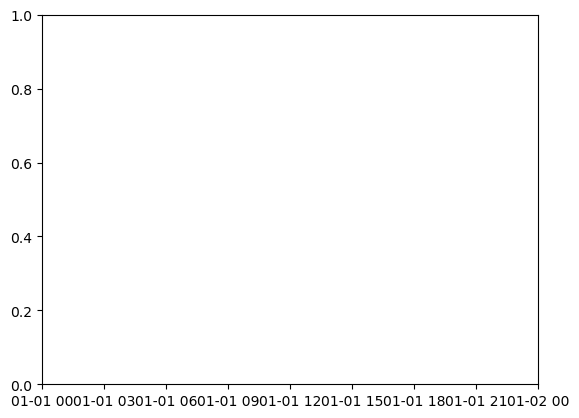

In [28]:
# Plot data with gaps in lines where data is missing
dataset_full.spkir_abj_cspp_downwelling_vector.plot.line(x="time", hue="spectra")
plt.title(' '.join([refdes, method, stream]))